# Analysis of the IAC Dataset

In [47]:
%matplotlib inline
import numpy as np
import pandas as pd

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import scipy
import math

import tensorflow as tf
import skflow

## Preprocessing

The [IAC corpus](https://nlds.soe.ucsc.edu/iac) of 10,000 comments is preprocessed into a training set (80%) and a test set (20%). We exctract only the responses for available question and response pairs within the corpus and assign to each both the nicenasty score and a boolean variable indicating whether the nicenasty score is positive or negative. We will use the former for regression and the latter for a classification based analysis.

## Regression

We begin by trying to train a regression algorithm on the nicenasty scores of the IAC response corpus. We will use a bag of words model to embed the text into a feature space and tf-idf for downscaling. We will use a random forest as our final regressor, which performs the best of those regressors we experimented with.

### Reading the data

In [38]:
train = pd.read_csv('../data/isnice_text_train.csv')
X_train, y_train = train.ix[:,2], train.ix[:,1]
test = pd.read_csv('../data/isnice_text_test.csv')
X_test, y_test = test.ix[:,2], test.ix[:,1]

### Training the regressor

In [39]:
text_reg = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('reg', RandomForestRegressor()),
])
text_reg = text_reg.fit(X_train, y_train)

### Results

Ultimately, our regression is unable to capture only a small portion of the signal in the data as shown in the plot below.

MSE: 1.973406
R-squared: 0.071382


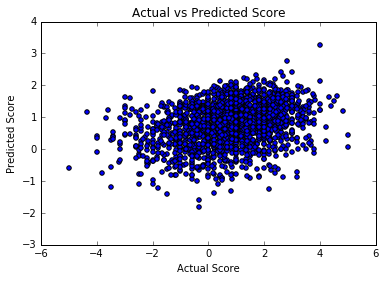

In [40]:
predicted = text_reg.predict(X_test)
MSE = metrics.regression.mean_squared_error(y_test, predicted)
print 'MSE: {0:f}'.format(MSE)
R2 = metrics.r2_score(y_test, predicted)
print 'R-squared: {0:f}'.format(R2)
plt.scatter(y_test, predicted)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Score')

## Classification

Regression seems difficult, but perhaps we can solve an easier classification problem. Let's just try to build a classifier to predict whether a response has a positive nicenasty score. We use the same bag of word ans tf-idf approach. We chose logistic regression as the classifier after testing a few others which perform less well.

### Reading the data

In [41]:
train = pd.read_csv('../data/isnice_text_train.csv')
X_train, y_train = train.ix[:,2], train.ix[:,3]
test = pd.read_csv('../data/isnice_text_test.csv')
X_test, y_test = test.ix[:,2], test.ix[:,3]

### Training the classifier

In [42]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression()),
])
text_clf = text_clf.fit(X_train, y_train)

### Results

We are able to obtain an accuracy of 73% (which increases to 74.4% with a little hyperparameter searching). This is only slightly better than a classifier which predicts all "True" which would achieve 71% accuracy on our test set.  The classification report below shows that our classifier tends to bias toward guessing True and misses a significant portion of the nasty comments.

In [43]:
predicted = text_clf.predict(X_test)
accur = np.mean(predicted == y_test)
print 'Accuracy: {0:f}'.format(accur)

Accuracy: 0.729537


### Hyperparameter Search and Results

In [44]:
from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1,4)],
              'tfidf__use_idf': (True, False),
              'clf__C': [0.1, 1, 5, 10],
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])

In [46]:
print "Best Parameters"
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
predicted = gs_clf.predict(X_test)
accur = np.mean(predicted == y_test)
print ""
print 'Accuracy: {0:f}'.format(accur)
print ""
print "Classification Report"
print(metrics.classification_report(y_test, predicted))

Best Parameters
clf__C: 10
tfidf__use_idf: True
vect__ngram_range: (1, 4)

Accuracy: 0.743772

Classification Report
             precision    recall  f1-score   support

      False       0.62      0.31      0.41       570
       True       0.77      0.92      0.84      1397

avg / total       0.72      0.74      0.71      1967



## Convolutional Neural Net

Convolutional neural networks have achieved [some success](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/) in text classification tasks. Here, we use the skflow package to build a simple CNN to see what kind of classification accuracy we can achieve. 

### Reading the data

In [48]:
train = pd.read_csv('../data/isnice_text_train.csv')
X_train, y_train = train.ix[:,2], train.ix[:,3]
test = pd.read_csv('../data/isnice_text_test.csv')
X_test, y_test = test.ix[:,2], test.ix[:,3]

### Processing the vocabulary

In [49]:
MAX_DOCUMENT_LENGTH = 100

vocab_processor = skflow.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)
X_train = np.array(list(vocab_processor.fit_transform(X_train)))
X_test = np.array(list(vocab_processor.transform(X_test)))

n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

Total words: 30545


### Defining the model

In [50]:
EMBEDDING_SIZE = 20
N_FILTERS = 10
WINDOW_SIZE = 20
FILTER_SHAPE1 = [WINDOW_SIZE, EMBEDDING_SIZE]
FILTER_SHAPE2 = [WINDOW_SIZE, N_FILTERS]
POOLING_WINDOW = 4
POOLING_STRIDE = 2

def cnn_model(X, y):
    """2 layer Convolutional network to predict from sequence of words
    to a class."""
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size, sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = skflow.ops.categorical_variable(X, n_classes=n_words,
        embedding_size=EMBEDDING_SIZE, name='words')
    word_vectors = tf.expand_dims(word_vectors, 3)
    with tf.variable_scope('CNN_Layer1'):
        # Apply Convolution filtering on input sequence.
        conv1 = skflow.ops.conv2d(word_vectors, N_FILTERS, FILTER_SHAPE1, padding='VALID')
        # Add a RELU for non linearity.
        conv1 = tf.nn.relu(conv1)
        # Max pooling across output of Convlution+Relu.
        pool1 = tf.nn.max_pool(conv1, ksize=[1, POOLING_WINDOW, 1, 1], 
            strides=[1, POOLING_STRIDE, 1, 1], padding='SAME')
        # Transpose matrix so that n_filters from convolution becomes width.
        pool1 = tf.transpose(pool1, [0, 1, 3, 2])
    with tf.variable_scope('CNN_Layer2'):
        # Second level of convolution filtering.
        conv2 = skflow.ops.conv2d(pool1, N_FILTERS, FILTER_SHAPE2,
            padding='VALID')
        # Max across each filter to get useful features for classification.
        pool2 = tf.squeeze(tf.reduce_max(conv2, 1), squeeze_dims=[1])
    # Apply regular WX + B and classification.
    return skflow.models.logistic_regression(pool2, y)


classifier = skflow.TensorFlowEstimator(model_fn=cnn_model, n_classes=2,
    steps=100, optimizer='Adam', learning_rate=0.005, continue_training=True)

### Training and evaluating the model

In [51]:
for i in xrange(4):
    classifier.fit(X_train, y_train, logdir='/tmp/tf_examples/word_cnn')
    score = metrics.accuracy_score(y_test, classifier.predict(X_test))
    print('Accuracy: {0:f}'.format(score))

Step #1, avg. loss: 1.18577
Step #11, avg. loss: 0.64192
Step #21, avg. loss: 0.60631
Step #31, avg. loss: 0.62822
Step #41, avg. loss: 0.64085
Step #51, avg. loss: 0.64577
Step #61, avg. loss: 0.62920
Step #71, avg. loss: 0.69686
Step #81, avg. loss: 0.62500
Step #91, avg. loss: 0.59615
Accuracy: 0.710219
Step #101, avg. loss: 0.53490
Step #111, avg. loss: 0.58363
Step #121, avg. loss: 0.57230
Step #131, avg. loss: 0.58556
Step #141, avg. loss: 0.90900
Step #151, avg. loss: 1.10923
Step #161, avg. loss: 2.35915
Step #171, avg. loss: 1.18820
Step #181, avg. loss: 0.91374
Step #191, avg. loss: 1.02682
Accuracy: 0.587697
Step #201, avg. loss: 1.13730
Step #211, avg. loss: 1.89021
Step #221, avg. loss: 2.09466
Step #231, avg. loss: 1.12773
Step #241, avg. loss: 1.80713
Step #251, avg. loss: 2.22226
Step #261, avg. loss: 6.69830
Step #271, avg. loss: 3.14421
Step #281, avg. loss: 1.21030
Step #291, avg. loss: 1.62504
Accuracy: 0.539908
Step #301, avg. loss: 1.81160
Step #311, avg. loss: 1.

### Results

The test set accuracy of the CNN swings wildly. I think this is caused by it overtraining on a fairly small set of training data on the large number of CNN parameters.

### Attribution

The above code is a modification of the code of the skflow authors which has been releashed under the Apache License below:

Copyright 2015-present Scikit Flow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.